In [1]:
# /kaggle/input/clc-xray/test/_annotations.coco.json

In [2]:
import os
import json
import glob

dataset_path = "/kaggle/input/clc-xray"

json_files = glob.glob(os.path.join(dataset_path, "*", "_annotations.coco.json"))
print("Annotation Files Found:", json_files)

annotation_path = os.path.join(dataset_path, "train", "_annotations.coco.json")

with open(annotation_path, "r") as f:
    json_data = json.load(f)

print("Keys in JSON:", json_data.keys())


Annotation Files Found: ['/kaggle/input/clc-xray/valid/_annotations.coco.json', '/kaggle/input/clc-xray/test/_annotations.coco.json', '/kaggle/input/clc-xray/train/_annotations.coco.json']
Keys in JSON: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


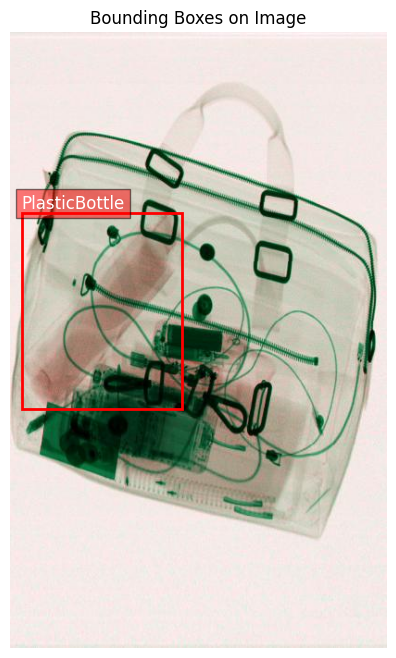

In [3]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

category_map = {cat["id"]: cat["name"] for cat in json_data["categories"]}

def plot_bboxes(image_dir, image_info, annotations):
    """Plots bounding boxes on an image using COCO annotations."""
    image_path = os.path.join(image_dir, image_info["file_name"])

    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return

    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to read image. Check file format.")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    for ann in annotations:
        x, y, w, h = ann["bbox"]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, category_map.get(ann["category_id"], "Unknown"), 
                color="white", fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis("off")
    plt.title("Bounding Boxes on Image")
    plt.show()

image_sample = json_data["images"][0]
image_dir = os.path.join(dataset_path, "train")  # Adjust for test/valid if needed
image_annotations = [ann for ann in json_data["annotations"] if ann["image_id"] == image_sample["id"]]

plot_bboxes(image_dir, image_sample, image_annotations)


In [4]:
import glob

train_images = glob.glob(os.path.join(dataset_path, "train", "*.*"))
test_images = glob.glob(os.path.join(dataset_path, "test", "*.*"))
valid_images = glob.glob(os.path.join(dataset_path, "valid", "*.*"))

print(f"Train Images: {len(train_images)} | Sample: {train_images[:5]}")
print(f"Test Images: {len(test_images)} | Sample: {test_images[:5]}")
print(f"Valid Images: {len(valid_images)} | Sample: {valid_images[:5]}")


Train Images: 3187 | Sample: ['/kaggle/input/clc-xray/train/14_40_57_902_png.rf.b22655f7f996cb15ebe22352da3ca316.jpg', '/kaggle/input/clc-xray/train/20_23_15_859_png.rf.fff05ae10df04be916c8686da7d07500.jpg', '/kaggle/input/clc-xray/train/14_41_06_754_png.rf.02656f934727d060b3c365360989d998.jpg', '/kaggle/input/clc-xray/train/15_27_02_225_png.rf.1d83d3ab8d6781927e65fd3813e36376.jpg', '/kaggle/input/clc-xray/train/11_26_16_589_png.rf.cbe70bafa3cfb2d566e63ff52a55b520.jpg']
Test Images: 957 | Sample: ['/kaggle/input/clc-xray/test/20_37_29_671_png.rf.1286d40d36684ffc548c8ec1040d32cb.jpg', '/kaggle/input/clc-xray/test/13_38_09_250_png.rf.b25716a99761f06fd425c06a18b0c6be.jpg', '/kaggle/input/clc-xray/test/06_52_33_484_png.rf.422794b05ac18ede6344152fd169ce51.jpg', '/kaggle/input/clc-xray/test/06_30_14_000_png.rf.c2d8f6768498d027eb5ed391a84365e9.jpg', '/kaggle/input/clc-xray/test/09_58_01_779_png.rf.cfc77bccc128b790c004e3acfd28c179.jpg']
Valid Images: 957 | Sample: ['/kaggle/input/clc-xray/vali

In [5]:
output_path = "/kaggle/working/clc-xray-yolo"
os.makedirs(output_path, exist_ok=True)

json_files = glob.glob(os.path.join(dataset_path, "*", "_annotations.coco.json"))

def convert_coco_to_yolo(json_path, split):
    """Convert COCO JSON to YOLO format and save annotations."""
    with open(json_path, "r") as f:
        data = json.load(f)

    category_map = {cat["id"]: cat["name"] for cat in data["categories"]}
    
    # Make YOLO annotation folder
    label_dir = os.path.join(output_path, split, "labels")
    os.makedirs(label_dir, exist_ok=True)
    
    # Process each annotation
    for ann in data["annotations"]:
        image_info = next(img for img in data["images"] if img["id"] == ann["image_id"])
        img_w, img_h = image_info["width"], image_info["height"]
        
        # YOLO format: Normalize bbox values
        x, y, w, h = ann["bbox"]
        x_center, y_center = x + w / 2, y + h / 2
        x_center /= img_w
        y_center /= img_h
        w /= img_w
        h /= img_h
        
        # Save annotation
        label_path = os.path.join(label_dir, os.path.splitext(image_info["file_name"])[0] + ".txt")
        with open(label_path, "a") as f:
            f.write(f"{ann['category_id']} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

    print(f"✅ YOLO annotations saved for {split} in {label_dir}")

# Convert all dataset splits
for json_file in json_files:
    split = os.path.basename(os.path.dirname(json_file))  # Extract train/test/valid
    convert_coco_to_yolo(json_file, split)


✅ YOLO annotations saved for valid in /kaggle/working/clc-xray-yolo/valid/labels
✅ YOLO annotations saved for test in /kaggle/working/clc-xray-yolo/test/labels
✅ YOLO annotations saved for train in /kaggle/working/clc-xray-yolo/train/labels


📊 Class Distribution: {'blade': 1597, 'VacuumCup': 1213, 'GlassBottle': 351, 'Cans': 409, 'scissors': 1201, 'Tin': 466, 'PlasticBottle': 3196, 'SprayCans': 571, 'CartonDrinks': 954, 'SwissArmyKnife': 496, 'dagger': 494, 'knife': 347}


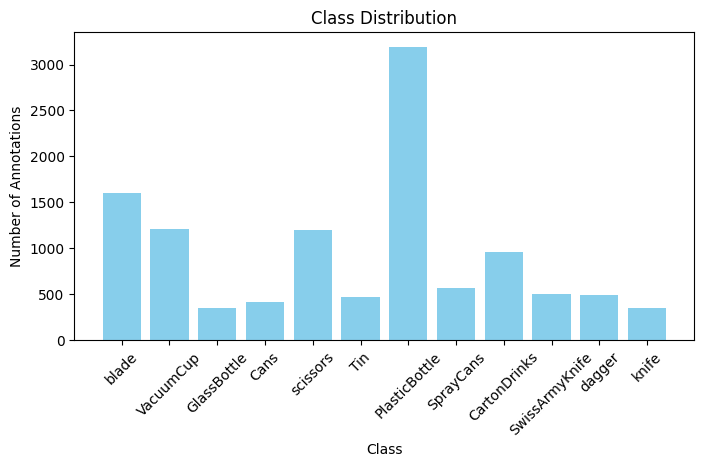

In [6]:
from collections import Counter

label_counts = Counter()

for json_file in json_files:
    with open(json_file, "r") as f:
        data = json.load(f)
    
    for ann in data["annotations"]:
        label_counts[ann["category_id"]] += 1

category_map = {cat["id"]: cat["name"] for cat in data["categories"]}
label_counts_named = {category_map[k]: v for k, v in label_counts.items()}

print("📊 Class Distribution:", label_counts_named)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(label_counts_named.keys(), label_counts_named.values(), color="skyblue")
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Annotations")
plt.title("Class Distribution")
plt.show()


In [7]:
import shutil

for split in ["train", "valid", "test"]:
    src_img_dir = os.path.join(dataset_path, split)
    dest_img_dir = os.path.join(output_path, split, "images")
    os.makedirs(dest_img_dir, exist_ok=True)

    # Move images
    for img_file in glob.glob(os.path.join(src_img_dir, "*.*")):
        shutil.copy(img_file, dest_img_dir)

print("✅ Dataset Organized in YOLO format!")


✅ Dataset Organized in YOLO format!


In [8]:
!pip install ultralytics --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 17.4 MB/s eta 0:00:0000:01


In [9]:
!pip install torch torchvision opencv-python numpy matplotlib pyyaml tqdm

In [10]:
import json
import glob

# Locate one annotation file (train set is usually the best choice)
annotation_file = glob.glob("/kaggle/input/clc-xray/train/_annotations.coco.json")[0]

# Load COCO JSON
with open(annotation_file, "r") as f:
    json_data = json.load(f)

# Extract category ID → Name mapping from the dataset
dataset_classes = {cat["id"]: cat["name"] for cat in json_data["categories"]}

# Print the actual class order from dataset
sorted_classes = [dataset_classes[i] for i in sorted(dataset_classes.keys())]
print("✅ Classes in correct order:", sorted_classes)


✅ Classes in correct order: ['gun-knife-wrench-pilers-scissors', 'Cans', 'CartonDrinks', 'GlassBottle', 'PlasticBottle', 'SprayCans', 'SwissArmyKnife', 'Tin', 'VacuumCup', 'blade', 'dagger', 'knife', 'scissors']


In [11]:
import yaml
import os

# Define dataset paths
dataset_path = "/kaggle/working/clc-xray-yolo"  # Update path if needed
yaml_path = os.path.join(dataset_path, "data.yaml")

# Correct class order
class_names = [
    'gun-knife-wrench-pilers-scissors', 'Cans', 'CartonDrinks', 'GlassBottle', 'PlasticBottle', 
    'SprayCans', 'SwissArmyKnife', 'Tin', 'VacuumCup', 'blade', 'dagger', 'knife', 'scissors'
]

# Prepare YAML structure
data_yaml = {
    "train": os.path.join(dataset_path, "train/images"),
    "val": os.path.join(dataset_path, "valid/images"),
    "test": os.path.join(dataset_path, "test/images"),
    "nc": len(class_names),  # Number of classes
    "names": class_names,  # Corrected order
}

# Save to YAML file with correct format
with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False, sort_keys=False)

print(f"✅ Updated `data.yaml` with correct class order at: {yaml_path}")


✅ Updated `data.yaml` with correct class order at: /kaggle/working/clc-xray-yolo/data.yaml


In [12]:
cat /kaggle/working/clc-xray-yolo/data.yaml

train: /kaggle/working/clc-xray-yolo/train/images
val: /kaggle/working/clc-xray-yolo/valid/images
test: /kaggle/working/clc-xray-yolo/test/images
nc: 13
names:
- gun-knife-wrench-pilers-scissors
- Cans
- CartonDrinks
- GlassBottle
- PlasticBottle
- SprayCans
- SwissArmyKnife
- Tin
- VacuumCup
- blade
- dagger
- knife
- scissors


In [13]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 117 not upgraded.


In [14]:
!git lfs install
!git clone https://huggingface.co/spaces/BoukamchaSmartVisions/Yolov10

Git LFS initialized.
Cloning into 'Yolov10'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 119 (delta 17), reused 0 (delta 0), pack-reused 71 (from 1)
Receiving objects: 100% (119/119), 1.08 MiB | 9.38 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Filtering content: 100% (7/7), 408.17 MiB | 104.15 MiB/s, done.


In [16]:
weights_path = "/kaggle/working/yolo_weights"
os.makedirs(weights_path, exist_ok=True)
print(f"✅ YOLO Weights folder created at: {weights_path}")

✅ YOLO Weights folder created at: /kaggle/working/yolo_weights


In [17]:
!mkdir -p /kaggle/working/yolo_weights
!mv Yolov10/yolov10n.pt /kaggle/working/yolo_weights/

In [18]:
from ultralytics import YOLO

yolo_weights_path = "/kaggle/working/yolo_weights/yolov10n.pt"  

if os.path.exists(yolo_weights_path):
    print("YOLOv10 weights found!")
    model = YOLO(yolo_weights_path)  
    model.info()
else:
    print("YOLOv10 weights not found! Check the path.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
YOLOv10 weights found!
YOLOv10n summary: 385 layers, 2,775,520 parameters, 2,775,504 gradients, 8.7 GFLOPs


In [19]:
dataset_path = "/kaggle/working/clc-xray-yolo"
yaml_path = os.path.join(dataset_path, "data.yaml")

# Verify dataset structure
print("Checking dataset structure...\n")
!ls "$dataset_path"

Checking dataset structure...

data.yaml  test  train	valid


In [20]:
dataset_path = "/kaggle/working/clc-xray-yolo"
yaml_path = os.path.join(dataset_path, "data.yaml")

yaml_content = f"""train: {dataset_path}/train/images
val: {dataset_path}/valid/images
test: {dataset_path}/test/images

nc: 13
names: ['gun-knife-wrench-pilers-scissors', 'Cans', 'CartonDrinks', 'GlassBottle', 
        'PlasticBottle', 'SprayCans', 'SwissArmyKnife', 'Tin', 'VacuumCup', 
        'blade', 'dagger', 'knife', 'scissors']
"""

# Overwrite data.yaml with the correct paths
with open(yaml_path, "w") as f:
    f.write(yaml_content)

print(f"✅ Updated `data.yaml` at: {yaml_path}")


✅ Updated `data.yaml` at: /kaggle/working/clc-xray-yolo/data.yaml


In [23]:
!cat "/kaggle/working/clc-xray-yolo/data.yaml"

train: /kaggle/working/clc-xray-yolo/train/images
val: /kaggle/working/clc-xray-yolo/valid/images
test: /kaggle/working/clc-xray-yolo/test/images

nc: 13
names: ['gun-knife-wrench-pilers-scissors', 'Cans', 'CartonDrinks', 'GlassBottle', 
        'PlasticBottle', 'SprayCans', 'SwissArmyKnife', 'Tin', 'VacuumCup', 
        'blade', 'dagger', 'knife', 'scissors']


In [24]:
from ultralytics import YOLO

# Load YOLOv10 model
model = YOLO("/kaggle/working/yolo_weights/yolov10n.pt")  # Path to weights

# Start training
model.train(
    data="/kaggle/working/clc-xray-yolo/data.yaml",  # Path to data.yaml
    epochs=50,
    batch=16,
    imgsz=640,
    optimizer="AdamW",
    device=0,  # Use GPU
    workers=2,
    project="/kaggle/working/Yolov10_results",  # Save results in Kaggle working directory
    name="clc_xray_yolov10",
    cache=True,
    augment=True,
    save=True,           # Ensure model saves after training
    save_period=5        # Save every 5 epochs
)

print("✅ YOLOv10 training started!")


Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/yolo_weights/yolov10n.pt, data=/kaggle/working/clc-xray-yolo/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=5, cache=True, device=0, workers=2, project=/kaggle/working/Yolov10_results, name=clc_xray_yolov10, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, sa

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


Overriding model.yaml nc=80 with nc=13

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.4MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/clc-xray-yolo/train/labels... 3186 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3186/3186 [00:02<00:00, 1159.26it/s]

train: New cache created: /kaggle/working/clc-xray-yolo/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (2.9GB RAM): 100%|██████████| 3186/3186 [00:04<00:00, 729.86it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/clc-xray-yolo/valid/labels... 956 images, 0 backgrounds, 0 corrupt: 100%|██████████| 956/956 [00:00<00:00, 1088.70it/s]

val: New cache created: /kaggle/working/clc-xray-yolo/valid/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.9GB RAM): 100%|██████████| 956/956 [00:01<00:00, 734.34it/s]


Plotting labels to /kaggle/working/Yolov10_results/clc_xray_yolov10/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/Yolov10_results/clc_xray_yolov10
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.11G      3.296      6.645      3.278          4        640: 100%|██████████| 200/200 [00:45<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:07<00:00,  4.10it/s]


                   all        956       2317     0.0307      0.327     0.0212     0.0086

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       3.1G      3.445      5.326      3.469          4        640: 100%|██████████| 200/200 [00:42<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.37it/s]


                   all        956       2317     0.0563      0.162      0.049     0.0219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.11G      3.152      4.716      3.254          4        640: 100%|██████████| 200/200 [00:42<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


                   all        956       2317      0.209       0.22      0.114     0.0614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.11G      2.929      4.227      3.096          4        640: 100%|██████████| 200/200 [00:41<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


                   all        956       2317      0.263      0.234      0.165     0.0889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.11G      2.755      3.848      2.954          3        640: 100%|██████████| 200/200 [00:42<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


                   all        956       2317      0.518      0.356      0.272      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.09G      2.587      3.474       2.83          8        640: 100%|██████████| 200/200 [00:41<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.36it/s]


                   all        956       2317      0.319      0.334      0.281      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.08G      2.505      3.306       2.78          6        640: 100%|██████████| 200/200 [00:42<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.27it/s]


                   all        956       2317      0.208      0.386      0.234      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.13G      2.417      3.101        2.7          5        640: 100%|██████████| 200/200 [00:42<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]


                   all        956       2317      0.565      0.408      0.398      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       3.1G      2.279       2.89      2.605          5        640: 100%|██████████| 200/200 [00:42<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.23it/s]


                   all        956       2317      0.429       0.47      0.447      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       3.1G      2.204      2.749      2.569          4        640: 100%|██████████| 200/200 [00:41<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


                   all        956       2317      0.394      0.481      0.417      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.13G      2.188      2.691      2.548          6        640: 100%|██████████| 200/200 [00:42<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]

                   all        956       2317      0.445      0.507      0.472      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       3.1G      2.129      2.525       2.51          5        640: 100%|██████████| 200/200 [00:42<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]

                   all        956       2317      0.418       0.52      0.491      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       3.1G      2.053      2.421      2.478          5        640: 100%|██████████| 200/200 [00:42<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.38it/s]


                   all        956       2317      0.462      0.528      0.493      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       3.1G      1.995      2.304      2.437          2        640: 100%|██████████| 200/200 [00:42<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.28it/s]


                   all        956       2317      0.526      0.531      0.531      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.12G      1.992      2.295      2.414          7        640: 100%|██████████| 200/200 [00:42<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.40it/s]

                   all        956       2317      0.489      0.562      0.545      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       3.1G      1.909      2.199      2.377          6        640: 100%|██████████| 200/200 [00:42<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


                   all        956       2317      0.528      0.523      0.539      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.08G      1.892      2.183      2.378          6        640: 100%|██████████| 200/200 [00:42<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]


                   all        956       2317      0.539       0.55      0.547      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       3.1G       1.83       2.04      2.318          4        640: 100%|██████████| 200/200 [00:42<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]

                   all        956       2317      0.522      0.565      0.545      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       3.1G      1.782      1.956      2.301          6        640: 100%|██████████| 200/200 [00:42<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.38it/s]

                   all        956       2317        0.5      0.581      0.556      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       3.1G      1.787       1.92       2.29          9        640: 100%|██████████| 200/200 [00:42<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]

                   all        956       2317      0.524      0.568      0.554      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       3.1G      1.728      1.878      2.258          5        640: 100%|██████████| 200/200 [00:42<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]

                   all        956       2317      0.577      0.589      0.599      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       3.1G      1.672      1.816      2.238          4        640: 100%|██████████| 200/200 [00:42<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.32it/s]

                   all        956       2317      0.615       0.54      0.608      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       3.1G      1.699      1.837      2.243          2        640: 100%|██████████| 200/200 [00:42<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]

                   all        956       2317      0.608      0.586       0.63      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.13G      1.666      1.762      2.234          5        640: 100%|██████████| 200/200 [00:42<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.18it/s]

                   all        956       2317      0.609      0.626      0.651      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       3.1G       1.65      1.748      2.215          3        640: 100%|██████████| 200/200 [00:42<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]

                   all        956       2317      0.571      0.601      0.611      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       3.1G      1.611      1.711      2.193          4        640: 100%|██████████| 200/200 [00:42<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.21it/s]

                   all        956       2317      0.625      0.635      0.666      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       3.1G      1.595      1.676      2.182         10        640: 100%|██████████| 200/200 [00:42<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]

                   all        956       2317      0.616      0.609       0.64      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.12G      1.553       1.61      2.165          4        640: 100%|██████████| 200/200 [00:42<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]

                   all        956       2317      0.594      0.653      0.657       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       3.1G      1.541      1.629       2.16          7        640: 100%|██████████| 200/200 [00:42<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.36it/s]

                   all        956       2317      0.653      0.653       0.69      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.08G      1.564      1.655      2.173          2        640: 100%|██████████| 200/200 [00:42<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]

                   all        956       2317      0.663      0.626      0.668      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       3.1G      1.505      1.537      2.139          7        640: 100%|██████████| 200/200 [00:42<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.30it/s]

                   all        956       2317       0.66      0.669      0.701      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.08G      1.487      1.497      2.131          6        640: 100%|██████████| 200/200 [00:42<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]

                   all        956       2317      0.662      0.644      0.699      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       3.1G      1.449      1.475      2.111          6        640: 100%|██████████| 200/200 [00:42<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]

                   all        956       2317      0.675      0.674      0.714      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       3.1G      1.445      1.447      2.114          8        640: 100%|██████████| 200/200 [00:42<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.28it/s]

                   all        956       2317      0.708      0.662      0.711       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.08G      1.419      1.422      2.099          5        640: 100%|██████████| 200/200 [00:42<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]

                   all        956       2317      0.704      0.697       0.73      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.08G      1.426      1.441      2.116          3        640: 100%|██████████| 200/200 [00:42<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.36it/s]

                   all        956       2317      0.719      0.642      0.718      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       3.1G      1.392      1.391       2.09          5        640: 100%|██████████| 200/200 [00:41<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.28it/s]

                   all        956       2317      0.724      0.662      0.732      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       3.1G       1.36      1.341       2.06          1        640: 100%|██████████| 200/200 [00:42<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.37it/s]

                   all        956       2317      0.739      0.679      0.739      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       3.1G      1.355      1.359      2.069          6        640: 100%|██████████| 200/200 [00:42<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.26it/s]

                   all        956       2317      0.739      0.677      0.751      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       3.1G      1.309      1.291      2.041          5        640: 100%|██████████| 200/200 [00:42<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.34it/s]

                   all        956       2317      0.741      0.691      0.749      0.583


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.08G      1.787      1.812      2.338          2        640: 100%|██████████| 200/200 [00:42<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.17it/s]

                   all        956       2317      0.759        0.7      0.763      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.08G      1.732      1.634      2.266          4        640: 100%|██████████| 200/200 [00:41<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.31it/s]

                   all        956       2317      0.781      0.726       0.78       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.08G      1.715      1.598      2.265          6        640: 100%|██████████| 200/200 [00:41<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.40it/s]

                   all        956       2317      0.748      0.709      0.774      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.08G      1.661      1.522      2.244          6        640: 100%|██████████| 200/200 [00:41<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.40it/s]

                   all        956       2317      0.785      0.738      0.796      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.08G      1.623      1.482      2.212          2        640: 100%|██████████| 200/200 [00:41<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.33it/s]

                   all        956       2317      0.778      0.742      0.794      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.08G      1.611      1.433      2.183          2        640: 100%|██████████| 200/200 [00:41<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.35it/s]

                   all        956       2317      0.877      0.724      0.796      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.08G      1.608      1.445        2.2          4        640: 100%|██████████| 200/200 [00:41<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.28it/s]

                   all        956       2317      0.782      0.734      0.798      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.08G      1.555      1.368      2.156          6        640: 100%|██████████| 200/200 [00:41<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.38it/s]

                   all        956       2317      0.801      0.736      0.806      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.08G      1.556      1.345      2.151          3        640: 100%|██████████| 200/200 [00:41<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]

                   all        956       2317      0.803      0.748      0.807      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       3.1G      1.536      1.342      2.137          4        640: 100%|██████████| 200/200 [00:41<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.26it/s]

                   all        956       2317      0.814      0.733      0.808      0.663



50 epochs completed in 0.686 hours.
Optimizer stripped from /kaggle/working/Yolov10_results/clc_xray_yolov10/weights/last.pt, 5.7MB
Optimizer stripped from /kaggle/working/Yolov10_results/clc_xray_yolov10/weights/best.pt, 5.7MB

Validating /kaggle/working/Yolov10_results/clc_xray_yolov10/weights/best.pt...
Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 285 layers, 2,699,486 parameters, 0 gradients, 8.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/30 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   3%|▎         | 1/30 [00:00<00:05,  5.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   7%|▋         | 2/30 [00:00<00:07,  3.90it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 3/30 [00:01<00:12,  2.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  13%|█▎        | 4/30 [00:01<00:10,  2.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  17%|█▋        | 5/30 [00:01<00:10,  2.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 6/30 [00:02<00:08,  2.94it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 7/30 [00:02<00:06,  3.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 8/30 [00:02<00:05,  3.88it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 9/30 [00:02<00:05,  4.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 10/30 [00:02<00:04,  4.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  37%|███▋      | 11/30 [00:03<00:04,  4.51it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 12/30 [00:03<00:03,  4.73it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  43%|████▎     | 13/30 [00:03<00:03,  4.97it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 14/30 [00:03<00:03,  5.07it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 15/30 [00:03<00:02,  5.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 16/30 [00:04<00:02,  5.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  57%|█████▋    | 17/30 [00:04<00:02,  5.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 18/30 [00:04<00:02,  5.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  63%|██████▎   | 19/30 [00:04<00:02,  5.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 20/30 [00:04<00:01,  5.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 21/30 [00:05<00:01,  5.45it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 22/30 [00:05<00:01,  5.62it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 23/30 [00:05<00:01,  5.54it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 24/30 [00:05<00:01,  5.48it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  83%|████████▎ | 25/30 [00:05<00:00,  5.68it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  87%|████████▋ | 26/30 [00:05<00:00,  5.52it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|█████████ | 27/30 [00:06<00:00,  5.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  93%|█████████▎| 28/30 [00:06<00:00,  5.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  97%|█████████▋| 29/30 [00:06<00:00,  5.68it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


                   all        956       2317      0.814      0.733      0.808      0.663
                  Cans         83         87      0.886      0.717      0.795      0.686
          CartonDrinks        208        228      0.944      0.904      0.967      0.789
           GlassBottle         32         45          0          0     0.0543     0.0368
         PlasticBottle        462        607      0.886      0.746       0.87      0.728
             SprayCans         87         96      0.729      0.476        0.6      0.492
        SwissArmyKnife        113        114      0.879      0.904      0.933      0.697
                   Tin         82         93      0.875       0.71      0.814      0.687
             VacuumCup        182        192      0.899      0.865       0.94        0.8
                 blade        263        398       0.95      0.862      0.936      0.691
                dagger        121        122      0.889      0.861      0.926      0.787
                 knif

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /kaggle/working/Yolov10_results/clc_xray_yolov10
✅ YOLOv10 training started!


In [25]:
import os

weights_dir = "/kaggle/working/Yolov10_results/clc_xray_yolov10/weights/"

if os.path.exists(weights_dir):
    print("✅ Checking available weights:\n")
    print(os.listdir(weights_dir))
else:
    print("⚠️ Weights directory does not exist!")


✅ Checking available weights:

['epoch40.pt', 'epoch15.pt', 'epoch10.pt', 'epoch30.pt', 'epoch5.pt', 'epoch25.pt', 'best.pt', 'epoch0.pt', 'epoch45.pt', 'epoch35.pt', 'last.pt', 'epoch20.pt']


In [26]:
import os
import shutil

# Define source and backup paths
weights_dir = "/kaggle/working/Yolov10_results/clc_xray_yolov10/weights/"
backup_path = "/kaggle/working/yolo_weights/yolov10_best.pt"

# Check if weights exist
if os.path.exists(os.path.join(weights_dir, "best.pt")):
    best_model_path = os.path.join(weights_dir, "best.pt")
elif os.path.exists(os.path.join(weights_dir, "last.pt")):
    best_model_path = os.path.join(weights_dir, "last.pt")
else:
    raise FileNotFoundError("⚠️ No weights file found in the directory!")

# Copy the best available model
shutil.copy(best_model_path, backup_path)
print(f"✅ YOLOv10 best model saved to {backup_path}")


✅ YOLOv10 best model saved to /kaggle/working/yolo_weights/yolov10_best.pt


In [28]:
# Load trained YOLOv10 model
model = YOLO("/kaggle/working/yolo_weights/yolov10_best.pt")

# Define test dataset path
test_yaml_path = "/kaggle/working/clc-xray-yolo/data.yaml"

# Evaluate on test set
metrics = model.val(data=test_yaml_path, split="test")

# Print metrics
print("**Test Set Evaluation Results**")
print(f"Precision: {metrics.box.p:.4f}")
print(f"Recall: {metrics.box.r:.4f}")
print(f"F1-Score: {metrics.box.f1:.4f}")
print(f"mAP@50: {metrics.box.map50:.4f}")
print(f"mAP@50-95: {metrics.box.map:.4f}")
print(f"IoU (if available): {metrics.box.iou:.4f}")

Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 285 layers, 2,699,486 parameters, 0 gradients, 8.3 GFLOPs


val: Scanning /kaggle/working/clc-xray-yolo/test/labels... 956 images, 0 backgrounds, 0 corrupt: 100%|██████████| 956/956 [00:00<00:00, 1188.17it/s]


val: New cache created: /kaggle/working/clc-xray-yolo/test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  7.75it/s]


                   all        956       1421      0.704      0.577      0.627      0.507
                  Cans         37         47      0.768      0.211      0.332      0.298
          CartonDrinks         46         51      0.757      0.706      0.764      0.586
           GlassBottle         83        109       0.22     0.0158     0.0982     0.0587
         PlasticBottle        488        590      0.709      0.654      0.701      0.547
             SprayCans         90        114      0.443     0.0789      0.119     0.0979
        SwissArmyKnife         17         17       0.85      0.824       0.87      0.649
                   Tin         45         49       0.63      0.633      0.662      0.537
             VacuumCup        314        321      0.824      0.818      0.866      0.755
                 blade         27         34      0.671      0.647      0.595      0.435
                dagger         19         19       0.85      0.789      0.854      0.743
                 knif

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.4ms preprocess, 4.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val
**Test Set Evaluation Results**


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [29]:
from ultralytics import YOLO
import os

# Define model weights path
weights_path = "/kaggle/working/yolo_weights/yolov10_best.pt"

# Check if the model weights exist
if not os.path.exists(weights_path):
    raise FileNotFoundError(f"⚠️ Model weights not found at: {weights_path}")

# Load the trained YOLOv10 model
model = YOLO(weights_path)
print("✅ YOLOv10 model loaded successfully!")

# Define test dataset path (using updated Kaggle paths)
test_yaml_path = "/kaggle/working/clc-xray-yolo/data.yaml"

# Run evaluation on the test dataset
metrics = model.val(data=test_yaml_path, split="test", imgsz=640, batch=16)

# Extract and print evaluation metrics
print("\n**📊 Test Set Evaluation Results**")
print(f"Precision: {metrics.box.p.mean():.4f}")
print(f"Recall: {metrics.box.r.mean():.4f}")
print(f"F1-Score: {metrics.box.f1.mean():.4f}")
print(f"mAP@50: {metrics.box.map50.mean():.4f}")
print(f"mAP@50-95: {metrics.box.map.mean():.4f}")

# Confirm results directory
print(f"\n✅ Results saved to: {metrics.save_dir}")


✅ YOLOv10 model loaded successfully!
Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 285 layers, 2,699,486 parameters, 0 gradients, 8.3 GFLOPs


val: Scanning /kaggle/working/clc-xray-yolo/test/labels.cache... 956 images, 0 backgrounds, 0 corrupt: 100%|██████████| 956/956 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  7.54it/s]


                   all        956       1421      0.704      0.577      0.627      0.507
                  Cans         37         47      0.768      0.211      0.332      0.298
          CartonDrinks         46         51      0.757      0.706      0.764      0.586
           GlassBottle         83        109       0.22     0.0158     0.0982     0.0587
         PlasticBottle        488        590      0.709      0.654      0.701      0.547
             SprayCans         90        114      0.443     0.0789      0.119     0.0979
        SwissArmyKnife         17         17       0.85      0.824       0.87      0.649
                   Tin         45         49       0.63      0.633      0.662      0.537
             VacuumCup        314        321      0.824      0.818      0.866      0.755
                 blade         27         34      0.671      0.647      0.595      0.435
                dagger         19         19       0.85      0.789      0.854      0.743
                 knif

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.4ms preprocess, 3.9ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val2

**📊 Test Set Evaluation Results**
Precision: 0.7042
Recall: 0.5775
F1-Score: 0.6084
mAP@50: 0.6269
mAP@50-95: 0.5074

✅ Results saved to: runs/detect/val2


In [30]:
import os

# Define paths
test_images_path = "/kaggle/working/clc-xray-yolo/test/images"  # Updated test images path
output_path = "/kaggle/working/yolov10_test_results"  # Updated output directory

# Create output directory if it does not exist
os.makedirs(output_path, exist_ok=True)

# Run inference and save results
results = model.predict(source=test_images_path, save=True, project=output_path)

print(f"✅ Predictions saved in: {output_path}")



image 1/956 /kaggle/working/clc-xray-yolo/test/images/05_20_27_625_png.rf.1b267931baa1f6e5d48667f95695d374.jpg: 640x608 2 VacuumCups, 46.1ms
image 2/956 /kaggle/working/clc-xray-yolo/test/images/05_24_05_796_png.rf.6194ae409d5a6b35cae0cea21bab968e.jpg: 640x480 1 PlasticBottle, 45.6ms
image 3/956 /kaggle/working/clc-xray-yolo/test/images/05_24_40_875_png.rf.9df32b927a67834ac6efc6631c0798d2.jpg: 640x640 (no detections), 10.5ms
image 4/956 /kaggle/working/clc-xray-yolo/test/images/05_25_25_703_png.rf.b3ffc7590a2072577e2c6a62a66c73dd.jpg: 640x640 1 VacuumCup, 9.9ms
image 5/956 /kaggle/working/clc-xray-yolo/test/images/05_27_15_406_png.rf.af1ec5b23304c5086affa15bbacd953a.jpg: 640x640 1 VacuumCup, 10.4ms
image 6/956 /kaggle/working/clc-xray-yolo/test/images/05_29_34_453_png.rf.b4ab31f1dd47ba90e59109ed8fbb45b0.jpg: 352x640 1 VacuumCup, 42.4ms
image 7/956 /kaggle/working/clc-xray-yolo/test/images/05_34_07_015_png.rf.a3df24d6667e9dd0e02ffbf7bcdea42a.jpg: 416x640 3 PlasticBottles, 39.2ms
image 

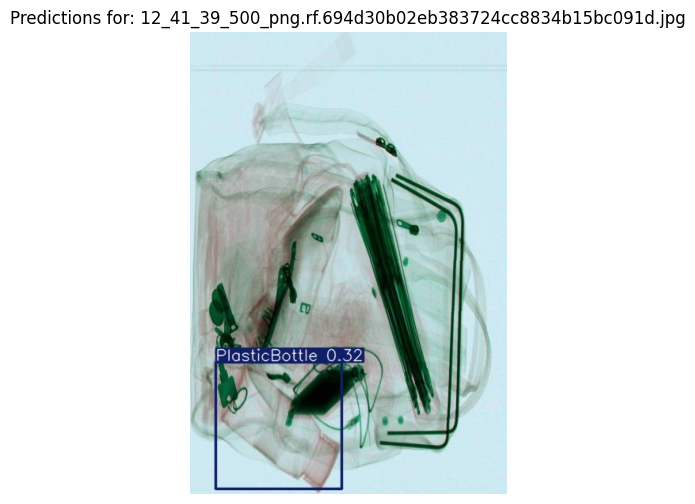

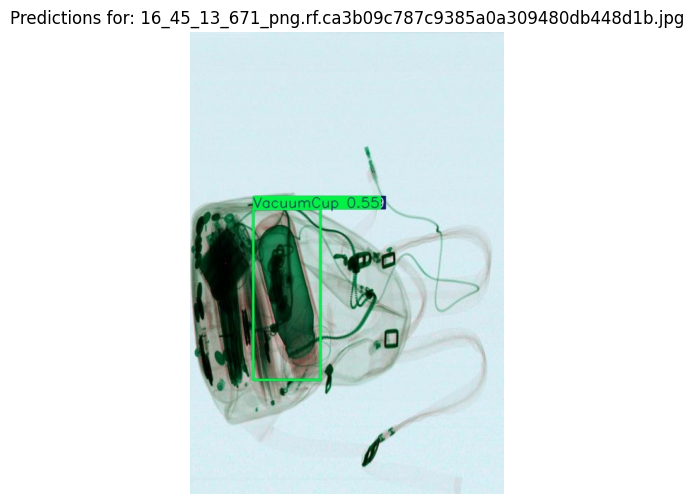

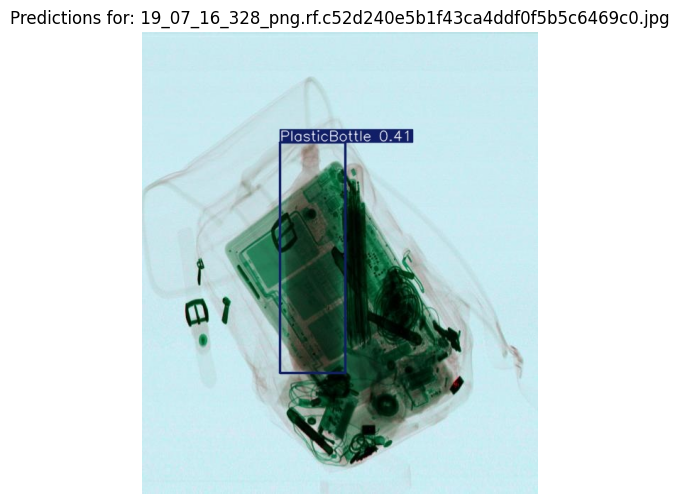

In [31]:
import cv2
import matplotlib.pyplot as plt
import random

# Select random test images
sample_images = random.sample(os.listdir(test_images_path), 3)

# Show test results
for img_name in sample_images:
    img_path = os.path.join(output_path, "predict", img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predictions for: {img_name}")
    plt.axis("off")
    plt.show()

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Define path to training results CSV
results_csv = "/kaggle/working/Yolov10_results/clc_xray_yolov10/results.csv"  # Updated path

# Load the data
df = pd.read_csv(results_csv)

# Extract epochs
epochs = df.index

print("✅ Training results CSV loaded successfully!")


✅ Training results CSV loaded successfully!


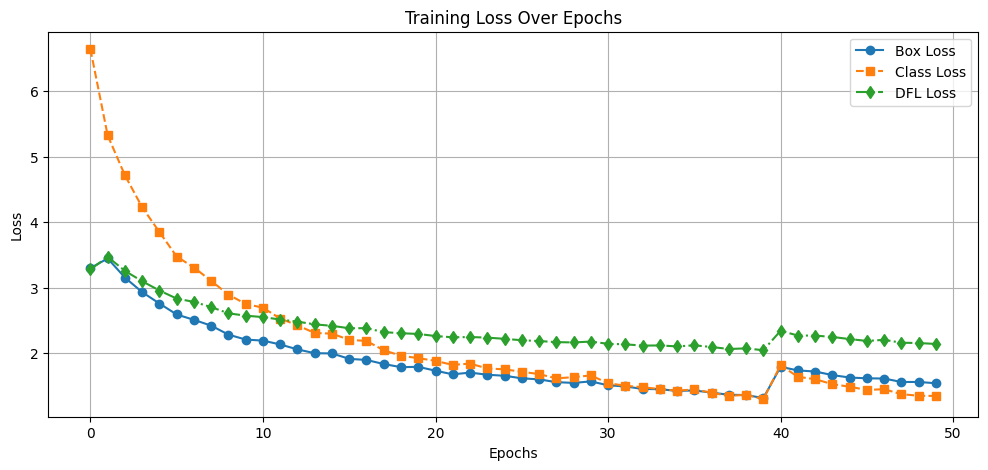

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Define path to training results CSV
results_csv = "/kaggle/working/Yolov10_results/clc_xray_yolov10/results.csv"

# Load the data
df = pd.read_csv(results_csv)

# Extract epochs
epochs = df.index

# Extract loss metrics
box_loss = df["train/box_loss"]
cls_loss = df["train/cls_loss"]
dfl_loss = df["train/dfl_loss"]

# Plot loss curves
plt.figure(figsize=(12, 5))
plt.plot(epochs, box_loss, label="Box Loss", linestyle='-', marker='o')
plt.plot(epochs, cls_loss, label="Class Loss", linestyle='--', marker='s')
plt.plot(epochs, dfl_loss, label="DFL Loss", linestyle='-.', marker='d')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


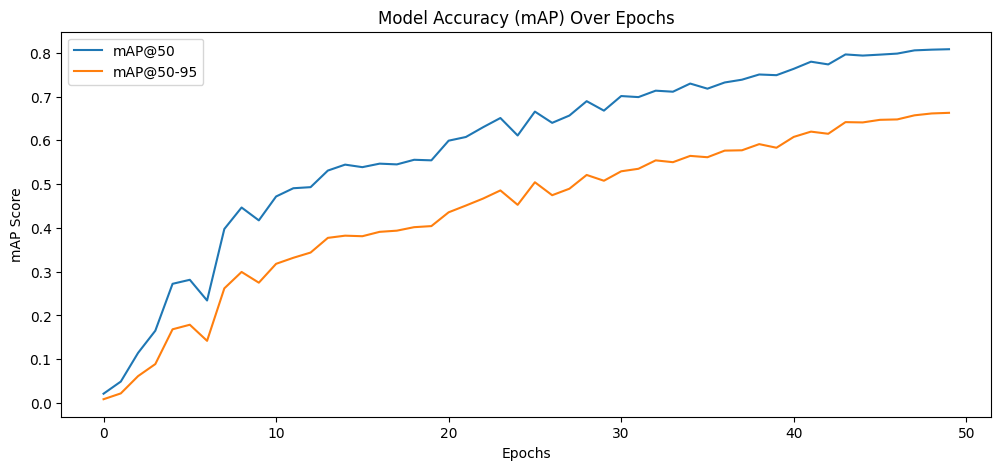

In [36]:
# Extract accuracy metrics
map50 = df["metrics/mAP50(B)"]
map50_95 = df["metrics/mAP50-95(B)"]

# Plot accuracy curves
plt.figure(figsize=(12, 5))
plt.plot(epochs, map50, label="mAP@50")
plt.plot(epochs, map50_95, label="mAP@50-95")
plt.xlabel("Epochs")
plt.ylabel("mAP Score")
plt.title("Model Accuracy (mAP) Over Epochs")
plt.legend()
plt.show()